In [1]:
from fastai.vision import *

In [2]:
#Dataset klasörümün path'ini oluşturuyorum.
path = Path('../input/beatiful-ugly')

In [3]:
#Klasörümün içindekilere bakıyorum.
path.ls()

[PosixPath('../input/beatiful-ugly/u'), PosixPath('../input/beatiful-ugly/b')]

In [4]:
#Oluşturduğum path'i kullanarak bir ImageDataBunch oluşturuyorum, classlar otomatik olarak klasör isimlerine bakarak oluşturuluyor.
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
       ds_tfms=get_transforms(), bs=64, size=224, num_workers=4).normalize(imagenet_stats)

In [5]:
data
#path olarak class klasörlerini içeren klasörü verdik.
#ImageDataBunch objesi otomatik olarak path içindeki klasörlerin
#her birini bir sınıf kabul etti.

ImageDataBunch;

Train: LabelList (388 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
u,u,u,u,u
Path: ../input/beatiful-ugly;

Valid: LabelList (97 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
b,b,b,b,b
Path: ../input/beatiful-ugly;

Test: None

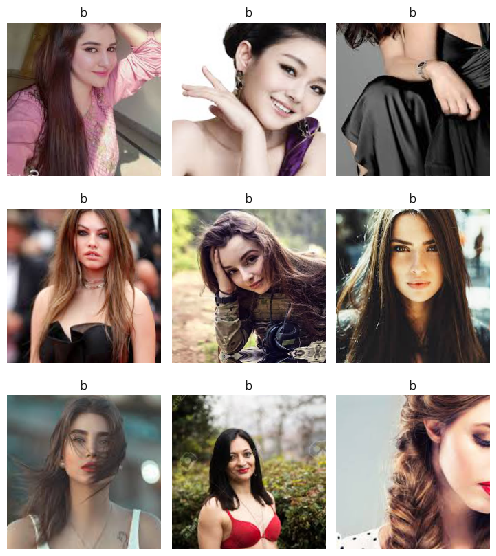

In [6]:
#Rastgele örneklere ve classlarına bakalım:
data.show_batch(rows=3, figsize=(7,8))

In [7]:
#class isimlerini, sayısını, training ve validation set size'larını görelim:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['b', 'u'], 2, 388, 97)

In [8]:
#bir cnn_learne oluşturacağım, transfer learning kullanacağım için model olarak resnet34 verdim, head kısmını dataya göre otomatik oluşturuyor.
learn = cnn_learner(data, models.resnet34, metrics= error_rate, model_dir="/tmp/model")
#burada model_dir vermem, kaggle ile ilgili bir şey daha sonra save işlemi yaptığımda bu adrese save edecek, bu adres geçici bi adres sanırım, bu modeli daha sonra alamıyorum.

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [9]:
#epoch size=10 ile modelimi eğitiyorum.
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.214353,0.612503,0.247423,00:06
1,1.047509,0.564672,0.175258,00:04
2,0.844467,0.556611,0.164948,00:04
3,0.731644,0.641411,0.144330,00:04
4,0.651948,0.578379,0.164948,00:04
5,0.573122,0.504932,0.164948,00:05
6,0.516494,0.489349,0.154639,00:04
7,0.464768,0.474186,0.144330,00:05
8,0.419259,0.467636,0.134021,00:05
9,0.384457,0.465361,0.134021,00:05


In [10]:
#bu eğitimde sadece head kısmı eğitildi, sonucu stage-1 olarak kaydediyorum.
learn.save('stage-1',True) #cnn_learner içinde belirtilen temp directory'e kaydetti sanıyorum.
#True diyerek kaydettiği path'i görebiliriz.

PosixPath('/tmp/model/stage-1.pth')

In [11]:
#eğitilen modelin performansını görmek isiyorum bu yüzden interpration'dan yararlanıyorum.
interp = ClassificationInterpretation.from_learner(learn) #learn ismindeki eğitilmiş learner objesini interpret ediyoruz.
#Unutma learn object içinde hem data var hem de architecture(şuan trained).

losses,idxs = interp.top_losses() #

len(data.valid_ds)==len(losses)==len(idxs) #true dönmesini beklerim.

True

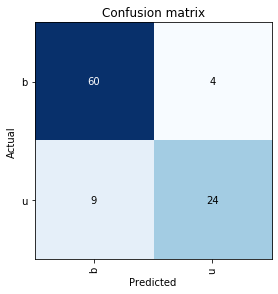

In [12]:
interp.plot_confusion_matrix()

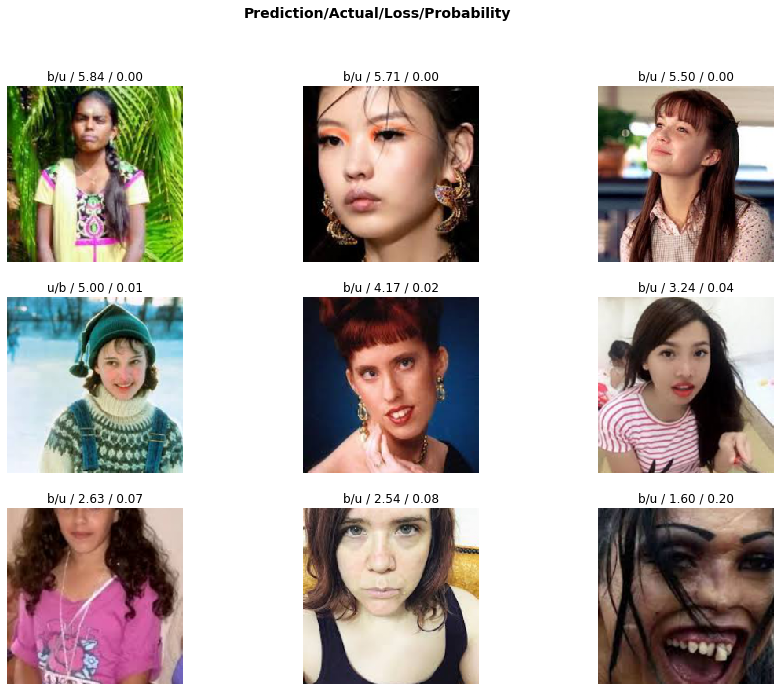

In [13]:
#Modelin en çok hata yaptığı örneklere bakıyorum: 
#Sadece valid setten mi yoksa hepsinden mi bilmiyorum?
interp.plot_top_losses(9, figsize=(15,11))
#prediction/actual/loss/probability of actual class

In [14]:
#Şimdi fine-tuning zamanı, artık body layers'ı da biraz eğitelim, ancak bu süreçte her layer'ı farklı bir learning rate ile eğitmeye çalışacağız.
#Bunun içinde de lr_finder'dan yararlanacağız.
learn.unfreeze()

In [15]:
learn.lr_find() # iyi bir plot aralığı vermezse, parametre olarak kendi plot aralığımızı verebiliriz.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.98E-05


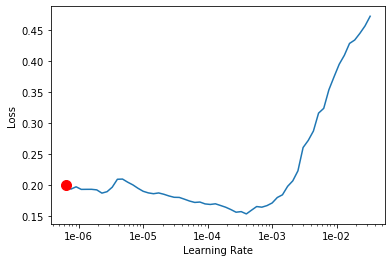

In [16]:
learn.recorder.plot(suggestion=True) #suggestion=True ile gerekli noktayı döndürebiliriz. #Min num gradient değerini seçiyoruz.

In [17]:
learn.fit_one_cycle(10, max_lr=slice(3e-6,1e-4)) #Fine tuning için max_lr slice olarak veriliyor ikinci parametre, stage1'de kullanılan lr'nin 10 kat küçüğü
#ilk parametre ise yukarıda plottan elde ediliyor.

epoch,train_loss,valid_loss,error_rate,time
0,0.234542,0.458839,0.123711,00:05
1,0.219722,0.450982,0.123711,00:05
2,0.199076,0.437510,0.123711,00:04
3,0.185375,0.430716,0.103093,00:05
4,0.173278,0.411048,0.103093,00:05
5,0.157373,0.402936,0.092783,00:05
6,0.149322,0.394956,0.092783,00:04
7,0.138741,0.394992,0.092783,00:04
8,0.129340,0.391008,0.092783,00:05
9,0.128996,0.395570,0.092783,00:05


In [18]:
learn.save('stage-2', True) #Modeli kaydediyoruz.

PosixPath('/tmp/model/stage-2.pth')

# **Temizlik yapalım, çok hata veren örnekleri silebiliriz.**

* Top losses indexlerini elde edip ImageCleaner ile silebiliriz
* ImageCleaner'ın image'ları diskten silmediğine dikkat et
* Sadece yeni bir csv file oluşturuyor 
* Bu file'ı kullanarak yeni bir imageDataBunch objesi oluşturabiliriz
* Tüm set üzerinde temizlik yapmak için, önce splitsiz bir dataset oluşturmalıyız.

In [19]:
from fastai.widgets import *

In [20]:
path #path'i kontrol ediyorum.

PosixPath('../input/beatiful-ugly')

In [21]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )
#splitsiz bir dataset oluşturuyorum.
db

ImageDataBunch;

Train: LabelList (485 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
u,u,u,u,u
Path: ../input/beatiful-ugly;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: ../input/beatiful-ugly;

Test: None

In [22]:
#Yeni databunch için yeni bir learner oluşturacağım, modeli stage-2'den load edeceğim.
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

#eğitilmiş son modeli, yeni sadece training'den oluşan dataset için çağırdık.
learn_cln.load('/tmp/model/stage-2');

In [23]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln) #modelimizin en çok hata yaptığı örnekler bulunuyor sanırım.

In [24]:
ImageCleaner(ds, idxs, Path("/kaggle/working")) #cleaned.csv girilen path'e yazılacak.
#Path olarak output'u kullanamıyorum sadece bunu kullanabiliyorum neden bilmiyorum.

#Birden fazla kişi olanları veya ekranda yazı olanları vesaire siliyorum.
#Bariz hatalı etiketleri değiştiriyorum.
#Burada modelin doğru veya yanlışına görmüyorum unutma, sadece datayı kendime göre manipüle ediyorum, 
#modelin etkisi şu olabilir: en yüksek hata yaptığı örnekleri veriyor. Tüm örnekleri veriyor mu bilmiyorum?

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [25]:
savedPath = Path("/kaggle/working") #temizlenmiş csv bu path'e konuldu.
savedPath.ls()

[PosixPath('/kaggle/working/cleaned.csv'),
 PosixPath('/kaggle/working/__notebook__.ipynb')]

In [26]:
#CSV dosyasından temizlenmiş dataset'i oluşturalım.
#np.random.seed(45)
dataCleaned = ImageDataBunch.from_csv(savedPath, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)


In [27]:
dataCleaned

ImageDataBunch;

Train: LabelList (388 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
u,u,u,u,u
Path: /kaggle/working;

Valid: LabelList (97 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
b,b,b,b,b
Path: /kaggle/working;

Test: None

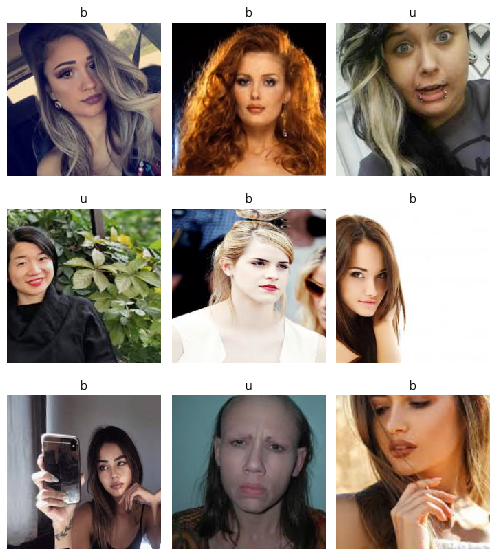

In [28]:
dataCleaned.show_batch(rows=3, figsize=(7,8))

# **Stage-2 Learner'ın temizlenmiş dataset performasına bakalım:**

In [29]:
#Yeni dataset ile yeni bir learner oluşturacağım
learnNew = cnn_learner(dataCleaned, models.resnet34, metrics=error_rate)
learnNew.load('/tmp/model/stage-2');

In [30]:
interp = ClassificationInterpretation.from_learner(learnNew) 
losses,idxs = interp.top_losses() #
len(dataCleaned.valid_ds)==len(losses)==len(idxs)

True

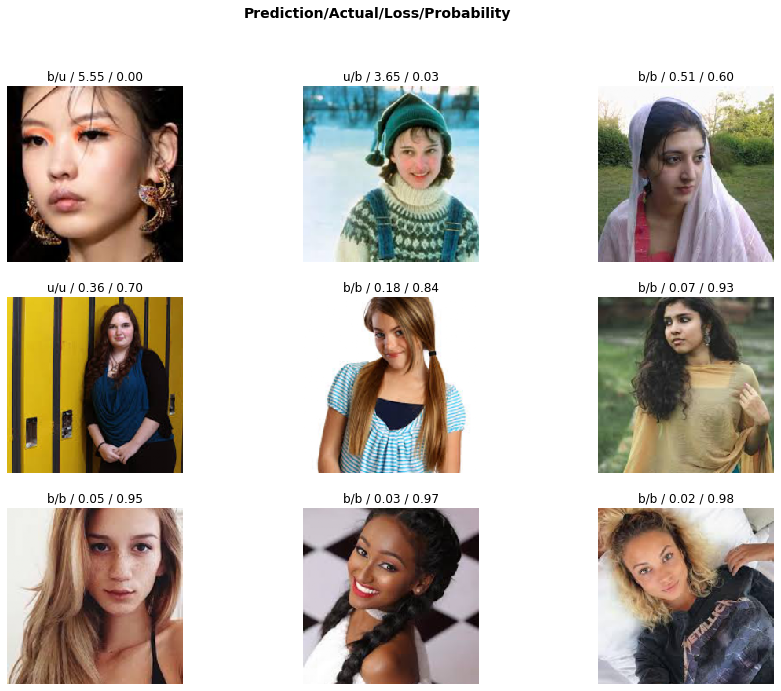

In [31]:
interp.plot_top_losses(9, figsize=(15,11))
#prediction/actual/loss/probability of actual class

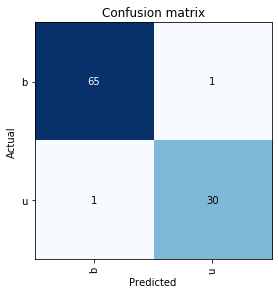

In [32]:
interp.plot_confusion_matrix()
#Performans bariz olarak arttı, dataCleaned'in validation set'i eski validation set ile aynı değil, buna rağmen performans arttı.
#Artması normal çünkü çok hata yapılan örnekleri sildim veya grubunu değiştirdim.
#Ancak bu cleaning süresince kafama göre iş yapmadım, zaten hatalı örnekler vardı onları değiştirdim.
#Bu yüzden bu yeni dataset ile yeni model eğitince de performansın bariz artmasını bekliyordum, ancak aşağıda bunu yapınca istediğim sonucu elde edemedim.
#Sebebini tam olarak çözemedim?

# **Yeni dataset ile yeni bir model eğitelim:**

In [33]:
#Dediğim gibi eski modelin performansı cleaned data için bariz arttı, yeni bir model eğitirsek de böyle olmasını bekliyorum ama bu sonucu elde edemedim neden acaba?
dataCleaned.classes, dataCleaned.c, len(dataCleaned.train_ds), len(dataCleaned.valid_ds)

(['b', 'u'], 2, 388, 97)

In [34]:
learnE = cnn_learner(dataCleaned, models.resnet34, metrics= error_rate, model_dir="/tmp/model")

In [35]:
learnE.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.079299,0.448883,0.216495,00:04
1,0.957867,0.336857,0.103093,00:04
2,0.812333,0.465089,0.123711,00:05
3,0.719806,0.579580,0.154639,00:05
4,0.636696,0.522195,0.144330,00:05
5,0.564464,0.538671,0.123711,00:04
6,0.516973,0.533552,0.134021,00:05
7,0.466707,0.492754,0.134021,00:04
8,0.428152,0.475722,0.134021,00:04
9,0.392614,0.475484,0.134021,00:05


In [36]:
learnE.unfreeze()

In [37]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.75E-05


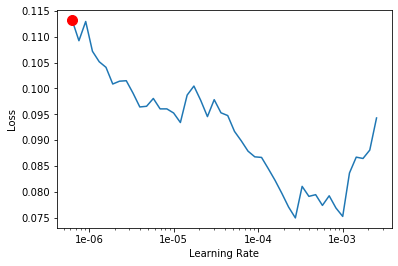

In [38]:
learn.recorder.plot(suggestion=True)

In [39]:
learnE.fit_one_cycle(10, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.192334,0.484711,0.134021,00:05
1,0.190672,0.478622,0.134021,00:05
2,0.197572,0.474443,0.134021,00:05
3,0.182860,0.470707,0.134021,00:05
4,0.174812,0.455291,0.134021,00:05
5,0.159216,0.447091,0.134021,00:05
6,0.154631,0.439947,0.134021,00:05
7,0.144357,0.438158,0.123711,00:05
8,0.140276,0.434463,0.123711,00:05
9,0.138798,0.437459,0.123711,00:04


In [40]:
interp = ClassificationInterpretation.from_learner(learnE) 
losses,idxs = interp.top_losses() #
len(dataCleaned.valid_ds)==len(losses)==len(idxs)

True

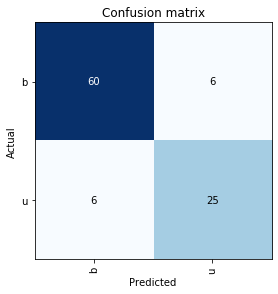

In [41]:
interp.plot_confusion_matrix()

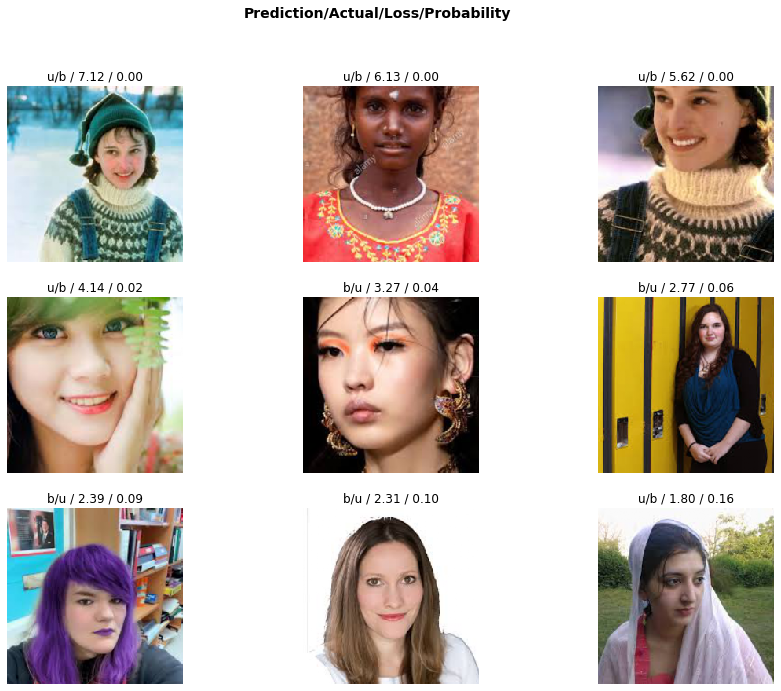

In [42]:
interp.plot_top_losses(9, figsize=(15,11))
#prediction/actual/loss/probability of actual class

In [43]:
learn.save('New_model',True)

PosixPath('/tmp/model/New_model.pth')

# **Farklı resimlerle test edelim:**

In [44]:
#testset klasörüne kendi yüklediğim bazı resimlerle modeli test edebiliriz:
imgPath = Path('../input/testset')

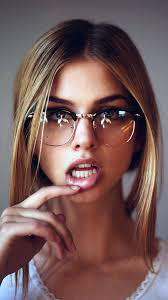

In [45]:
img = open_image(imgPath/'indir (18).jpg')
img

In [46]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class,outputs

(Category u, tensor([0.2713, 0.7287]))

In [47]:
pred_class,pred_idx,outputs = learnE.predict(img)
pred_class,outputs

(Category b, tensor([0.5114, 0.4886]))

In [48]:
#Modeli export edebilirim, böylece daha sonra kullanabilirim bunun için aşağıdaki adresi kullanıyorum, ve çalıştırdıktan sonra commit ediyorum.
learnE.export(file = Path("/kaggle/working/export.pkl"))
#Daha sonra export.pkl dosyasını outputs kısmından indirebilirim, sonra bunu yeni bir sistemde input olarak verip kullanabilirim.

#Kaggle'ın file sistemi biraz kafamı karıştırıyor ama şimdilik bu şekilde kullanmaya devam edelim.